# The Titanic: A Good Reason to Travel First Class?
_Paolo Perrotta, August 24th, 2017_

It's a common notion that rich passengers on the RMS Titanic had higher survival rates than humble third class passengers. Is that really true? Let's do some fact-checking using the [Titanic data set from Kaggle](https://www.kaggle.com/c/titanic/data).


I pre-downloaded the data file locally. Let's load it in a _pandas_ data frame and peek at the first few rows:

In [1]:
import pandas as pd

passengers = pd.DataFrame.from_csv('./titanic_data.csv')
passengers.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

Amongst other things we know how each passenger travelled (_Cabin_, _Class_, _Fare_, ...) and crucially, whether he/she survived the sinking. Our hyphotesis is that higher travel fares correlate with higher rates of survival. Let's reduce the data set to the two columns that we're interested in: _Fare_ (how much each passengers paid for the trip) and _Survived_:

In [2]:
passengers = passengers[['Fare', 'Survived']]

Here are a few statistics over the entire data set:

In [3]:
passengers.describe()

Fare    Survived
count  891.000000  891.000000
mean    32.204208    0.383838
std     49.693429    0.486592
min      0.000000    0.000000
25%      7.910400    0.000000
50%     14.454200    0.000000
75%     31.000000    1.000000
max    512.329200    1.000000

So we have 891 people in our data set. _Survived_ is just a boolean variable -- either a 0 or a 1. _Fare_ varies from a minimum of zero (possibly for members of the crew) to an exorbitant 512. (It's unclear in the documentation of the dataset what the currency is. (I assume that the currency used is US dollars, although that is not clear from the documentation on Kaggle. In any case, our analysis wouldn't change).

One thing worth noting is that very high fares are definitely outliers: a whopping 75% of passengers paid 31$ or less. Just to be sure, let's plot the density of fares:

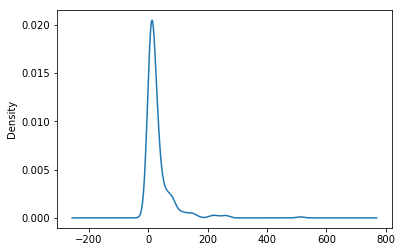

In [12]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

passengers['Fare'].plot(kind='kde')

Indeed, the plot has a large spike a bit above 0, and just a few small ripples over 150\$ or so. This indicates that just a tiny number of passengers paid over 150\$ to travel. Knowing this, let's split the passengers into buckets based on how much they paid, but let's cluster all luxury fares into a couple of wider bucket:

This looks like a reasonable clustering. The smaller buckets have at least around 16-30 people, which seems a decent number to get meaningful survival statistics. The first buckets contain many more passengers than that, but it seems that it wouldn't make much sense to split them further. (I tried, and I found that a large number of passengers would be clustered in the 7-8\$ bucket anyway).

Now that we have buckets, we can plot the mean survival for each bucket:

In [5]:
bucket_intervals = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 150, 1000]
spending_categories = passengers.groupby([pd.cut(passengers['Fare'], bucket_intervals)])
spending_categories.count()

Fare  Survived
Fare                       
(0, 10]       321       321
(10, 20]      179       179
(20, 30]      142       142
(30, 40]       58        58
(40, 50]       16        16
(50, 60]       38        38
(60, 70]       17        17
(70, 80]       31        31
(80, 90]       17        17
(90, 150]      28        28
(150, 1000]    29        29

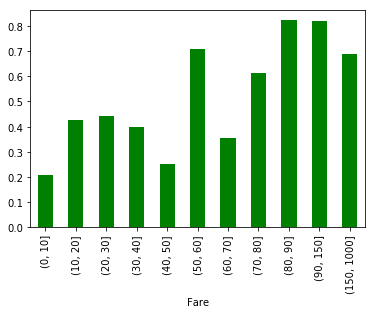

In [6]:
spending_categories['Survived'].mean().plot.bar(color='g');

Sure, enough, there seems to be a trend here. People paying less than 10\$ make up the most crowded bucket, and they also have a dismal survival rate around 20%. People paying more seem to fare progressively better.

We have an outstanding exception: people in the (40, 50] and (60, 70] ranges seem to do pretty bad. That might be an artifact of our bucket size. These two buckets contain relatively few people, and that might impact our statistics. Let's try a slightly different approach, by asking _pandas_ to create similar-sized buckets:

In [7]:
spending_categories = passengers.groupby([pd.qcut(passengers['Fare'], q=7)])
spending_categories.count()

Fare  Survived
Fare                             
(-0.001, 7.75]      140       140
(7.75, 8.05]        145       145
(8.05, 12.475]       98        98
(12.475, 19.258]    128       128
(19.258, 27.9]      128       128
(27.9, 56.929]      125       125
(56.929, 512.329]   127       127

Now all buckets include between 98 and 140 passengers. Let's take a look at the histogram:

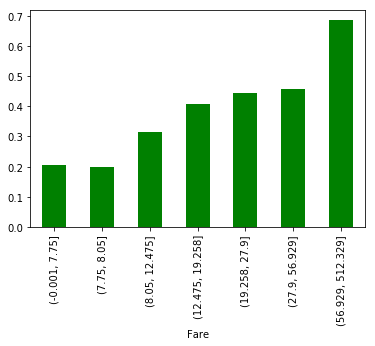

In [8]:
spending_categories['Survived'].mean().plot.bar(color='g');

Now the trend is even clearer. The more people spent, the higher chances of survival they got.

Two words of warning. First: as ever, correlation does not imply causation. We still don't know why higher fares are correlated with higher survival. Maybe the higher-class cabins had better access to the bridge and safety boats, or maybe people manning safety boats tended to give precedence to better-dressed passengers. We can just take note that there seems to be a correlation here.

And here is a second warning: I'm carefully saying that there _seems_ to be a correlation. This is not a formal statistical analysis, so we don't know if this apparent correlation is statistically significant. A slightly more formal approach would be to calculate Pearson's _r_ for the correlation, like this:

In [9]:
passengers['Survived'].corr(passengers['Fare'], method='pearson')

0.25730652238496227

This seems to be a pretty high Pearson's _r_. By comparison, let's reload the data and investigate the correlation between survival and a few variables that we expected to be less related to survival:

In [10]:
passengers = pd.DataFrame.from_csv('./titanic_data.csv')

survived_to_siblings = passengers['Survived'].corr(passengers['SibSp'], method='pearson')
print("Correlation between survival and number of siblings/spouses on board: \t{}".format(survived_to_siblings))

survived_to_parents = passengers['Survived'].corr(passengers['Parch'], method='pearson')
print("Correlation between survival and number of parents on board: \t\t{}".format(survived_to_parents))

survived_to_age = passengers['Survived'].corr(passengers['Age'], method='pearson')
print("Correlation between survival and age: \t\t\t\t\t{}".format(survived_to_age))

Correlation between survival and number of siblings/spouses on board: 	-0.03532249888573559
Correlation between survival and number of parents on board: 		0.08162940708348365
Correlation between survival and age: 					-0.07722109457217764


These findings are consistent with our expectation that the fare is a good predictor of survival, while the number of siblings/spouses/parents and the age are not as correlated.

Based on [this calculator](http://www.socscistatistics.com/pvalues/pearsondistribution.aspx), our _r_ of 0.2573, for our population of 891 passengers, is highly statistical significant, with a P-Value under 0.00001. This is still not a well-designed statistical analysis, but let's stop here and put our findings in layman's terms: if I were to travel on the RMS Titanic in 1912, I would spend as much money as I can to get a luxury spot. My life could depend on it.